# GFP mutant prediction

In this notebook, we try to classify GFP mutants into a "bright" and a "dark" class, using UniRep to encode the GFP protein sequences.

This notebook is also available on binder, where you can re-run the analysis from your browser. Have a look at the binder section in the readme for more information.

In [1]:
import numpy as np
import pandas as pd
import janitor

from functools import partial

In [2]:
wt ="SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK"

In [3]:
def aa_pos(mut):
    """
    Return mutation position from mutation string.

    Example: A111C -> 111
    """
    if not mut:
        return mut
    else:
        return int(mut[2:-1])


def aa_letter(mut):
    """
    Return mutation letter from mutation string.

    Example: A111C -> C
    """
    if not mut:
        return mut
    else:
        return mut[-1]


def mut2seq(mutation_string, wt_sequence, delimiter=":"):
    """
    Reconstruct full mutant sequence given mutation string.

    Example mutation_strings:
    - A111C
    - A111T; V130A
    - A111T; Q194R; N249I; N251Y; H255Y
    """
    if mutation_string is None or mutation_string == "":
        return wt_sequence

    mutations = mutation_string.split(delimiter)
    mutant_sequence = list(wt_sequence)  # mutant_sequence is a list
    for mut in mutations:
        position = aa_pos(mut)
        letter = aa_letter(mut)
        if position == 0:
            raise ValueError(
                f"""
            The mutation string {mut} is invalid.
            It has "0" as its position.
            """
            )
        if position > len(wt_sequence):
            raise ValueError(
                f"""
            The mutation string {mut} is invalid.
            Its position is greater than the length of the WT sequence.
            """
            )
        mutant_sequence[
            position #- 1
        ] = letter  # -1 is necessary because the list is zero-indexed
    return "".join(l for l in mutant_sequence)

In [4]:
def count_mutations(x):
    if x == '':
        return 0
    else:
        return len(x.split(":"))


In [5]:
mut2gfp = partial(mut2seq, wt_sequence=wt)

## Prepare data

In [6]:
data = (pd.read_csv("data/amino_acid_genotypes_to_brightness.tsv", sep='\t')
        .fill_empty("aaMutations", "")
        .filter_string("aaMutations", search_string="\*", complement=True)
        .transform_column("aaMutations", mut2gfp, "sequence")
        .transform_column("medianBrightness", lambda x: np.log(x), "log_bright")
        .transform_column("sequence", lambda x: len(x), "length")
        .transform_column("aaMutations", count_mutations, "mutation_count")
       )

In [7]:
data.head(3)

,aaMutations,uniqueBarcodes,medianBrightness,std,sequence,log_bright,length,mutation_count
0,,3645,3.719212,0.106992,SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...,1.313512,237,0
1,SA108D,1,1.301030,NaN,SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...,0.263156,237,1
2,SA108D:SN144D:SI186V:SM231T:SL234P,1,1.301031,NaN,SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...,0.263157,237,5


In [8]:
data.query("aaMutations.str.contains(r'[A-Z]2[A-Z]')").head(1)

,aaMutations,uniqueBarcodes,medianBrightness,std,sequence,log_bright,length,mutation_count
16351,SG2A,2,3.818888,0.119126,SKAEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...,1.339959,237,1


In [9]:
data.mutation_count.unique()

array([ 0,  1,  5,  4,  2,  6,  3,  7,  8, 11, 12, 10,  9, 13, 14, 15])

In [10]:
data.length.unique()

array([237])

## Get reps

We embed the sequences in chunks, to not run out of memory. If you have a lot of memory at your disposal, you can increase chunk size or rep all sequences at once (see commented out code below).

In [11]:
from jax_unirep import get_reps

/home/kummear1/anaconda/envs/jax-unirep-gfp/lib/python3.7/site-packages/jax_unirep/evotuning.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/home/kummear1/anaconda/envs/jax-unirep-gfp/lib/python3.7/site-packages/jax/lib/xla_bridge.py:119: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [12]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

In [13]:
h_final_l, c_final_l, h_avg_l = [], [], []

In [14]:
for seqs in chunker(data.sequence.values, 1000):
    hf, cf, ha = get_reps(seqs)
    h_final_l.append(hf)
    c_final_l.append(cf)
    h_avg_l.append(ha)

In [15]:
h_final = np.concatenate(h_final_l, axis=0)
c_final = np.concatenate(c_final_l, axis=0)
h_avg = np.concatenate(h_avg_l, axis=0)

In [16]:
# h_final, c_final, h_avg = get_reps(data.sequence.values)

In [17]:
h_avg.shape

(51715, 1900)

In [18]:
data["h_avg"] = h_avg.tolist()
data["h_final"] = h_final.tolist()
data["c_final"] = c_final.tolist()

In [19]:
def fusion(x):
    return np.concatenate((x.h_final,x.c_final, x.h_avg))

In [20]:
data = data.join_apply(fusion, "unirep_fusion")

In [21]:
data.head(3)

,aaMutations,uniqueBarcodes,medianBrightness,std,sequence,log_bright,length,mutation_count,h_avg,h_final,c_final,unirep_fusion
0,,3645,3.719212,0.106992,SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...,1.313512,237,0,"[0.6212356686592102, 0.10203030705451965, 10.4...","[0.005276355426758528, -0.047913096845149994, ...","[0.0008092806092463434, 0.01394092757254839, 0...","[0.005276355426758528, -0.047913096845149994, ..."
1,SA108D,1,1.301030,NaN,SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...,0.263156,237,1,"[0.5923959016799927, 0.12201326340436935, 10.6...","[0.005335634108632803, -0.04914676025509834, 0...","[0.0006889698561280966, 0.021215006709098816, ...","[0.005335634108632803, -0.04914676025509834, 0..."
2,SA108D:SN144D:SI186V:SM231T:SL234P,1,1.301031,NaN,SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFI...,0.263157,237,5,"[1.2923187017440796, 0.3601371645927429, 10.44...","[0.0052352058701217175, -0.05025511980056763, ...","[0.0010605393908917904, 0.06153017282485962, 0...","[0.0052352058701217175, -0.05025511980056763, ..."


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
sns.set_style("white")
sns.set_context(context="paper", font_scale=1.5)

In [24]:
df = pd.DataFrame.from_dict(dict(zip(data['h_avg'].index, data['h_avg'].values))).T
df['brightness'] = data["medianBrightness"].values
df.set_index(data['aaMutations'], inplace=True)
df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,1891,1892,1893,1894,1895,1896,1897,1898,1899,brightness
aaMutations,,,,,,,,,,,,,,,,,,,,,
,0.621236,0.102030,10.404504,-9.851444,0.681564,0.803212,0.554590,-3.610229,-13.569923,-0.201451,...,1.974337,-1.937303,8.058511,-2.392448,2.331100,0.566051,1.272536,0.719893,-1.457668,3.719212
SA108D,0.592396,0.122013,10.691099,-9.943564,0.761884,0.857018,0.494301,-3.944474,-11.979288,-0.212918,...,2.032164,-1.899304,7.547935,-2.495019,2.111458,0.537725,0.898870,1.317870,-1.442424,1.301030
SA108D:SN144D:SI186V:SM231T:SL234P,1.292319,0.360137,10.445380,-9.859782,1.181590,0.620896,-0.091127,-4.014988,-10.069128,-0.030979,...,1.701077,-2.218032,8.227721,-2.382942,1.220523,-0.325793,0.217424,1.653794,-0.368597,1.301031


In [25]:
df_bnry = df.copy()
df_bnry["brightness"] = (df["brightness"] < 2.5).astype(int)

In [26]:
X, y = df_bnry.shuffle().get_features_targets(target_column_names=['brightness'])

In [27]:
print(X.shape, y.shape)

(51715, 1900) (51715, 1)


# Training and Testing

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, ShuffleSplit, cross_val_predict, KFold
from sklearn import preprocessing

### Logistic Regression on binary brightness

In [29]:
X_pp = preprocessing.scale(X)

In [30]:
logreg = LogisticRegression(max_iter=300)

In [31]:
# with paLogisticRegressionlel_backend("dask"):
cv = KFold(n_splits=5)
scores = cross_val_score(logreg, X_pp, y.values.ravel(), cv=cv, scoring='accuracy')
preds = cross_val_predict(logreg, X_pp, y.values.ravel(), cv=cv)

/home/kummear1/anaconda/envs/jax-unirep-gfp/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/kummear1/anaconda/envs/jax-unirep-gfp/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

In [32]:
scores

array([0.89751523, 0.88958716, 0.89712849, 0.89538819, 0.90070579])

In [33]:
scores.mean()

0.8960649714782946

In [34]:
from sklearn.metrics import confusion_matrix

In [35]:
labels = [0, 1]
cm = confusion_matrix(y, preds, labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [36]:
cm

array([[0.93179779, 0.06820221],
       [0.15364343, 0.84635657]])

In [37]:
classes = ["Dark", "Bright"]

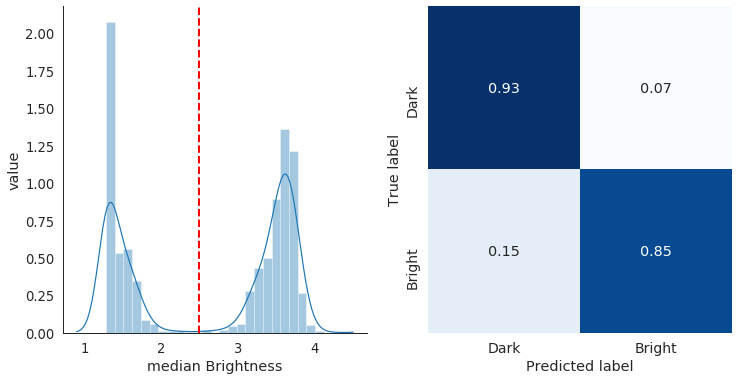

In [40]:
fig, (ax1, ax2) = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)

sns.distplot(data["medianBrightness"], ax=ax1)
ax1.axvline(x=2.5, c="r", ls="--", lw=2)
ax1.set(xlabel="median Brightness", ylabel="value")
sns.despine()

df_cm = pd.DataFrame(
    cm, index=classes, columns=classes, 
)

heatmap = sns.heatmap(df_cm, 
                      annot=True, 
                      fmt=".2f", 
                      cmap="Blues",
                      cbar=False,
                      ax=ax2
                     )

ax2.set_yticklabels(heatmap.yaxis.get_ticklabels(), rotation=90, fontsize=14)
ax2.set_xticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, fontsize=14)
ax2.set_ylabel('True label')
ax2.set_xlabel('Predicted label')
plt.savefig("figures/top_model.png", bbox_inches='tight', dpi=200)